Colunas carregadas:
Index(['Data', 'Hora (UTC)', 'Temp. Ins. (C)', 'Temp. Max. (C)',
       'Temp. Min. (C)', 'Umi. Ins. (%)', 'Umi. Max. (%)', 'Umi. Min. (%)',
       'Pto Orvalho Ins. (C)', 'Pto Orvalho Max. (C)', 'Pto Orvalho Min. (C)',
       'Pressao Ins. (hPa)', 'Pressao Max. (hPa)', 'Pressao Min. (hPa)',
       'Vel. Vento (m/s)', 'Dir. Vento (m/s)', 'Raj. Vento (m/s)',
       'Radiacao (KJ/m²)', 'Chuva (mm)'],
      dtype='object')

Após limpeza:
                      Temp   Umi  Vento  Rad  Chuva
datetime                                           
2025-09-01 00:00:00  17.70  97.0  2.400  0.0    0.0
2025-09-01 01:00:00  17.69  97.1  2.395  0.0    0.0
2025-09-01 02:00:00  17.68  97.2  2.390  0.0    0.0
2025-09-01 03:00:00  17.67  97.3  2.385  0.0    0.0
2025-09-01 04:00:00  17.66  97.4  2.380  0.0    0.0

✔️ Arquivo salvo em data/dados_tratados.csv

Shape final do dataset de modelagem: (2183, 33)

Tamanhos:
Treino: (1746, 32)
Teste: (437, 32)

===== LinearRegression =====
RMSE: 

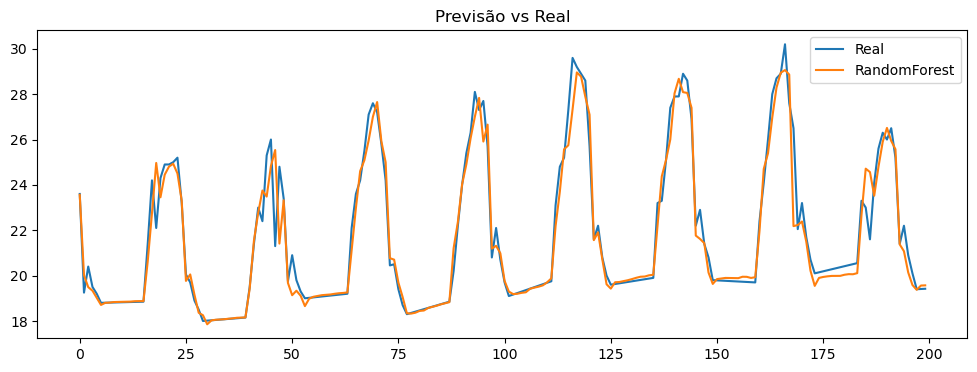

In [8]:
# ==============================================================
# 1) IMPORTS
# ==============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import mlflow
import mlflow.sklearn
import os

# ==============================================================
# 2) CARREGANDO O CSV BRUTO
# ==============================================================
df_raw = pd.read_csv("data/generatedBy_react-csv.csv", sep=";")

print("Colunas carregadas:")
print(df_raw.columns)

# --------------------------------------------------------------
# Converter colunas numéricas para float (remove ',')
# --------------------------------------------------------------
numeric_cols = [
    'Temp. Ins. (C)', 'Temp. Max. (C)', 'Temp. Min. (C)',
    'Umi. Ins. (%)', 'Umi. Max. (%)', 'Umi. Min. (%)',
    'Pto Orvalho Ins. (C)', 'Pto Orvalho Max. (C)', 'Pto Orvalho Min. (C)',
    'Pressao Ins. (hPa)', 'Pressao Max. (hPa)', 'Pressao Min. (hPa)',
    'Vel. Vento (m/s)', 'Dir. Vento (m/s)', 'Raj. Vento (m/s)',
    'Radiacao (KJ/m²)', 'Chuva (mm)'
]

df_raw[numeric_cols] = (
    df_raw[numeric_cols]
    .replace(",", ".", regex=True)
    .apply(pd.to_numeric, errors="coerce")
)

# Corrigir valores estranhos na coluna "Hora (UTC)"
df_raw["Hora (UTC)"] = df_raw["Hora (UTC)"].astype(str)

def fix_hour(h):
    h = h.strip()

    # caso perfeito: 0–23
    if h.isdigit() and len(h) <= 2:
        return int(h)

    # caso com 3 dígitos "100" -> "10"
    if len(h) == 3 and h.isdigit():
        return int(h[:-1])

    # caso com 4 dígitos "930" -> "9"
    if len(h) == 4 and h.isdigit():
        return int(h[:-2])

    # fallback: tenta converter
    try:
        return int(h)
    except:
        return None  # vira NaN e será ignorado

df_raw["HoraCorrigida"] = df_raw["Hora (UTC)"].apply(fix_hour)

# Remover horas inválidas (fora do intervalo 0–23)
df_raw = df_raw[(df_raw["HoraCorrigida"] >= 0) & (df_raw["HoraCorrigida"] <= 23)]

# ==============================================================
# 3) CRIAÇÃO DA COLUNA DATETIME
# ==============================================================
df_raw["datetime"] = pd.to_datetime(
    df_raw["Data"] + " " + df_raw["HoraCorrigida"].astype(str).str.zfill(2) + ":00",
    dayfirst=True
)

df_raw = df_raw.set_index("datetime")

# ==============================================================
# 4) SELECIONAR SOMENTE O NECESSÁRIO
# ==============================================================
df = df_raw[[
    "Temp. Ins. (C)",
    "Umi. Ins. (%)",
    "Vel. Vento (m/s)",
    "Radiacao (KJ/m²)",
    "Chuva (mm)"
]].copy()

df.columns = ["Temp", "Umi", "Vento", "Rad", "Chuva"]

# ==============================================================
# 5) LIMPEZA E INTERPOLAÇÃO
# ==============================================================
df = df.replace([-9999, -9999.0, 9999, 9999.0], np.nan)
df = df.resample("H").mean()
df = df.interpolate(method="time")

df["Rad"] = df["Rad"].fillna(0)  # Radiação sem leitura vira zero

print("\nApós limpeza:")
print(df.head())

# ==============================================================
# 6) SALVAR DATASET TRATADO
# ==============================================================
os.makedirs("data", exist_ok=True)
df.to_csv("data/dados_tratados.csv")
print("\n✔️ Arquivo salvo em data/dados_tratados.csv")

# ==============================================================
# 7) FEATURE ENGINEERING
# ==============================================================
df_model = df.copy()

lags = [1, 2, 3, 6, 12, 24]
for lag in lags:
    df_model[f"Temp_lag_{lag}"] = df_model["Temp"].shift(lag)
    df_model[f"Umi_lag_{lag}"] = df_model["Umi"].shift(lag)
    df_model[f"Vento_lag_{lag}"] = df_model["Vento"].shift(lag)
    df_model[f"Rad_lag_{lag}"] = df_model["Rad"].shift(lag)

df_model["hour"] = df_model.index.hour
df_model["hour_sin"] = np.sin(2 * np.pi * df_model["hour"] / 24)
df_model["hour_cos"] = np.cos(2 * np.pi * df_model["hour"] / 24)

# Target → previsão para 1 hora à frente
df_model["Temp_future_1h"] = df_model["Temp"].shift(-1)

df_model = df_model.dropna()

print("\nShape final do dataset de modelagem:", df_model.shape)

# ==============================================================
# 8) SEPARAÇÃO TREINO / TESTE
# ==============================================================
X = df_model.drop(columns=["Temp_future_1h"])
y = df_model["Temp_future_1h"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("\nTamanhos:")
print("Treino:", X_train.shape)
print("Teste:", X_test.shape)

# ==============================================================
# 9) FUNÇÃO DE TREINO + MLflow
# ==============================================================
def treinar_modelo(nome, modelo):

    with mlflow.start_run(run_name=nome):

        # Treinar
        modelo.fit(X_train, y_train)
        pred = modelo.predict(X_test)

        # Métricas
        rmse = mean_squared_error(y_test, pred, squared=False)
        mae = mean_absolute_error(y_test, pred)

        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("mae", mae)

        # ================================
        # SALVAR MODELO LOCAL + ENVIAR PARA O MLflow COMO ARTEFATO
        # ================================
        path = f"{nome}_model"
        mlflow.sklearn.save_model(modelo, path)   # salva localmente
        mlflow.log_artifacts(path, artifact_path=nome)  # envia ao MLflow
        # ================================

        print(f"\n===== {nome} =====")
        print("RMSE:", rmse)
        print("MAE:", mae)

        return pred


# ==============================================================
# 10) RODAR MODELOS
# ==============================================================
pred_lr = treinar_modelo("LinearRegression", LinearRegression())
pred_rf = treinar_modelo("RandomForest", RandomForestRegressor(
    n_estimators=200,
    random_state=42
))

# ==============================================================
# 11) PLOT COMPARAÇÃO VISUAL
# ==============================================================
plt.figure(figsize=(12,4))
plt.plot(y_test.values[:200], label="Real")
plt.plot(pred_rf[:200], label="RandomForest")
plt.legend()
plt.title("Previsão vs Real")
plt.show()


In [7]:
import shutil
import os

for pasta in ["LinearRegression_model", "RandomForest_model"]:
    if os.path.exists(pasta):
        shutil.rmtree(pasta)
        print(f"Removido: {pasta}")


Removido: LinearRegression_model
